In [9]:
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import pandas as pd
import os
import ROOT
import uproot
import uproot_methods
from scipy import interpolate
import matplotlib._color_data as mcd
import matplotlib.patches as mpatch
from scipy.optimize import curve_fit, fsolve
from matplotlib.patches import Ellipse, Polygon
import sys
sys.path.append("../AutoDQM/CSC-DQM-ML-master/dqmml")
import glob
import pickle
import sklearn

In [10]:
from modules.histCollection import HistCollection
from modules.histCollection import HistCleaner
from modules.dqmpca import DQMPCA

In [11]:
runs_validate = []
hists_validate = []
year = 2018
norm_cut = 10000
max_bins = None
title = None
lumi_json = None
pkl_dir="models/pca/CSC/{year}/"
pkl_dir = pkl_dir.format(year=year)
plot = "Segments/hSnSegments"
dname = plot.split('/')[0]
hname = plot.split('/')[1]
hpath = "DQMData/Run {}/CSC/Run summary/CSCOfflineMonitor"
pkl_name = os.path.join(pkl_dir,"{0}_{1}.pkl".format(dname, hname))

Load a previously compiled dataset or query 

In [ ]:
#runs_validate = np.load("runs_validate.npy")
#hists_validate = np.load("hists_validate.npy",allow_pickle=True)

In [12]:
if year ==2018:
        fnamesD =glob.glob("/eos/cms/store/group/comm_dqm/DQMGUI_data/Run2018/SingleMuon/*/DQM_V0001_R000*__SingleMuon__Run2018D-PromptReco-v2__DQMIO.root")
        fnamesABC = glob.glob("/eos/cms/store/group/comm_dqm/DQMGUI_data/Run2018/SingleMuon/*/DQM_V0001_R000*__SingleMuon__Run2018*-17Sep2018-*__DQMIO.root")
        fnames= fnamesD +fnamesABC
        
if year ==2017:
    fnames = []
    fnames =glob.glob("/eos/cms/store/group/comm_dqm/DQMGUI_data/Run2017/SingleMuon/*/DQM_V0001_R000*__SingleMuon__Run2017*-17Nov2017-v1__DQMIO.root")
    
if year ==2016:
    fnames = glob.glob("/eos/cms/store/group/comm_dqm/DQMGUI_data/Run2016/SingleMuon/*/DQM_V0001_R000*__SingleMuon__Run2016*-21Feb2020_UL2016_HIPM-v1__DQMIO.root")

In [13]:
for fname in fnames:
    run = int(fname.split("/")[-1].split("__")[0][-6:])
    #Corrupted file
    if run == 315267:
        continue
    f = uproot.open(fname)
    #Fetch all the 1D histograms into a list
    histograms =f[hpath.format(run)].allitems(filterclass=lambda cls: issubclass(cls, uproot_methods.classes.TH1.Methods))
    for name, roothist in histograms:
        name = name.decode("utf-8")
        name = name.replace(";1", "")
        #Grab the 1D histogram we want
        h = roothist.numpy()
        #print(h)
        if plot == name: 
            h = roothist.numpy()
            #Include only histograms that have enough events
            #if norm_cut is None or HistogramIntegral(h) >= norm_cut:
            if max_bins==None:
                nbins = len(h[0])
            else:
                nbins = min(len(h[0]), max_bins)
            hists_validate.append(h)
            runs_validate.append(run)

Load the model for the histogram class

In [14]:
possible_pickles = glob.glob(pkl_dir+"{0}_{1}.pkl".format(dname, hname))

In [15]:
for pkl_name in possible_pickles:
    with open(pkl_name, 'rb') as pickle_file:
        pca_obj = pickle.load(pickle_file)

In [18]:
#HistogramIntegral returns the total number of events
def HistogramIntegral(hist):
    return sum(hist[0][i] for i in range(len(hist[0])))

In [20]:
def PCATest(np_data, pca_obj, n_components):

    # Transform data in terms of principle component vectors
    transf = pca_obj.transform(np_data.reshape(1,-1))
    # Zero out components beyond n_components cap
    transf[0,n_components:] *= 0
    # Reconstruct data using N components
    reco_data = pca_obj.inverse_transform(transf)
    reco_data = reco_data.flatten()
    # Get sum of squared errors
    sse = np.sqrt(np.sum((reco_data - np_data)**2))

    return sse, reco_data

## Perturbation

In [16]:
from copy import deepcopy
import random
def perturb_abnormal(hist):
    count = 0
    while True:
        count +=1
        i = random.choice(range(len(hist[0])))
        if hist[0][i]>(HistogramIntegral(hist)*0.07):
        #if hist[0][i]>0:
            a = deepcopy(hist)
            a[0][i]=0
            return a
        if count>20:
            index = np.argmax(hist[0])
            a = deepcopy(hist)
            a[0][index]=0
            return a
        
        
def perturb_normal(hist):
    while True:
        i = random.choice(range(len(hist[0])))
        a = deepcopy(hist)
        a[0][i]=hist[0][i]*0.8
        return a

In [21]:
norm_with_perturb = [] #storing the histograms that have been perturbed and normalized  
with_perturb = [] #storing the histograms that have been perturbed
results = [] #PCA SSE results
runs = []
for i in range(len(hists_validate)):
    n = hists_validate[i]
    if HistogramIntegral(n)==0: #skip empty histograms
        continue
    with_perturb.append(n)
    norm = np.multiply(n,1/HistogramIntegral(n))
    x = perturb_normal(norm)[0]
    y = perturb_abnormal(norm)[0]
    n_components=3
    sse1, x1 = PCATest(x, pca_obj, n_components)
    norm_with_perturb.append(x)
    results.append(sse1)
    sse2, x2 = PCATest(y, pca_obj, n_components)
    norm_with_perturb.append(y)
    results.append(sse2)
    runs.append(runs_validate[i])

In [22]:
#Segment the results since all the even entries are normal perturbation and all the odd are abnormal perturbation
norm_results =results[::2]
abnorm_results =results[1::2]

## Statistics for Confusion Matrix Given Threshold

In [27]:
validate_true = []
for n in norm_results:
    if n<0.025:
        validate_true.append(1)
    else:
        validate_true.append(0)

In [28]:
validate_false = []
for n in abnorm_results:
    if n>=0.025:
        validate_false.append(1)
    else:
        validate_false.append(0)

In [29]:
sum(validate_true)

514

In [30]:
len(validate_true)

596

In [31]:
sum(validate_false)

596

In [32]:
len(validate_false)

596

In [53]:
false_positive = getIndex(validate_true,0)
true_negative = getIndex(validate_false,0)

### Adjusting Actual Normal Labels 

I wrote code for adjusting certain histogram's labels, though the graphs I've submitted/included before did not include this step (which could account for the high false positive)  \
**Jump to next section if no relabeling needed**

In [ ]:
#storing the histogram integral of validation for double checking of true anomaly (for example, we may want to consider very low event data as abnormal, even though the perturbation is within normal range)
validate_sum = []
for n in with_perturb:
    validate_sum.append(sum(n[0]))

In [ ]:
validate_sum_norm = validate_sum[::2]

In [ ]:
move_to_false_index= []

In [ ]:
for i in range(len(validate_sum_norm)):
    if validate_sum_norm[i] <10000:
        move_to_false_index.append(i)

In [611]:
norm_results = np.array(norm_results)
move_to_false_results = norm_results[move_to_false_index]

In [612]:
move_to_false_results = move_to_false_results.tolist()

In [614]:
#Updated to be correct
abnorm_results = abnorm_results+move_to_false_results

In [616]:
norm_results = [x for i, x in enumerate(norm_results) if i not in move_to_false_index ]

**Another type of relabeling**: tried to relabel based on false positives that have low events, though this could be too post-hoc; experts insighted needed for correct labeling

In [575]:
validate_sum = np.array(validate_sum)
validate_positive_sum = validate_sum[false_positive]

In [514]:
runs = np.array(runs)

In [606]:
a = np.array(validate_positive_sum)
a = a<700
b = [i for i, x in enumerate(a) if x]

In [609]:
#index_to_move=false_positive[:10]+false_positive[-3:]
index_to_move = b

In [ ]:
move_to_false_index = index_to_move 

Repeat previous code for relabeling

### ROC Curve

In [54]:
label = [1]*len(abnorm_results)+ [0]*len(norm_results)

In [55]:
y =  abnorm_results +norm_results 

In [56]:
fpr_rt_lm, tpr_rt_lm, threshold = sklearn.metrics.roc_curve(label, y)

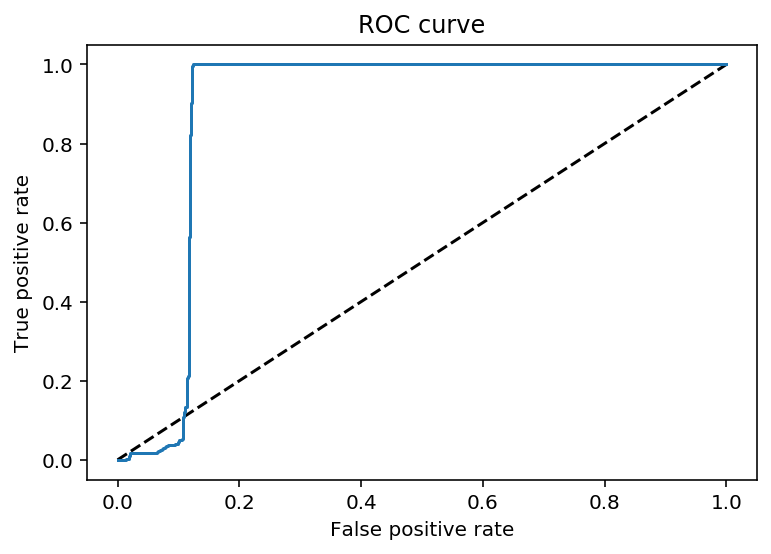

In [57]:
plt.title('ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [58]:
threshold

array([1.92786945e+00, 9.27869448e-01, 6.54869359e-01, 6.24660722e-01,
       6.06129145e-01, 5.46014593e-01, 5.40930312e-01, 4.96479987e-01,
       4.70102689e-01, 4.46534490e-01, 4.38180066e-01, 4.36009140e-01,
       4.35228141e-01, 4.33587073e-01, 4.05699228e-01, 4.00150143e-01,
       3.99553643e-01, 3.95092962e-01, 3.94188506e-01, 3.86530019e-01,
       3.71610524e-01, 3.71522215e-01, 3.64718370e-01, 3.60681560e-01,
       3.60271204e-01, 3.58794364e-01, 3.50182119e-01, 3.44274424e-01,
       3.35477978e-01, 3.25658368e-01, 3.23764636e-01, 3.13978077e-01,
       3.06808731e-01, 2.86250320e-01, 2.71958817e-01, 2.66002765e-01,
       2.38993907e-01, 2.29670086e-01, 2.24993226e-01, 2.24310278e-01,
       2.15762025e-01, 2.03149918e-01, 1.86872210e-01, 1.17965812e-01,
       1.14345929e-01, 9.84849987e-02, 9.68694090e-02, 8.46995570e-02,
       8.44536345e-02, 8.37289527e-02, 8.35068844e-02, 7.10337416e-02,
       7.09721409e-02, 6.79159416e-02, 6.79105975e-02, 6.70419035e-02,
      

### Simple graphing 

In [59]:
def getIndex(a, num):
    ret = []
    for i in range(len(a)):
        if a[i]==num:
            ret.append(i)
    return ret

In [60]:
#RUN 317296
specific = false_positive[-4]
specific_hist = with_perturb[specific]

In [61]:
specific_hist

(array([4.0000e+00, 1.1000e+02, 1.2600e+03, 3.7680e+03, 9.6130e+03,
        1.5117e+04, 1.8057e+04, 1.9133e+04, 1.8547e+04, 1.7209e+04,
        1.5373e+04, 1.3239e+04, 1.0941e+04, 9.0320e+03, 7.0050e+03,
        5.6310e+03, 4.3070e+03, 3.5010e+03, 2.6130e+03, 2.0860e+03,
        1.6420e+03, 1.2170e+03, 8.4300e+02, 7.3100e+02, 5.3500e+02,
        4.4700e+02], dtype=float32),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5,
        21.5, 22.5, 23.5, 24.5, 25.5]))

<BarContainer object of 26 artists>

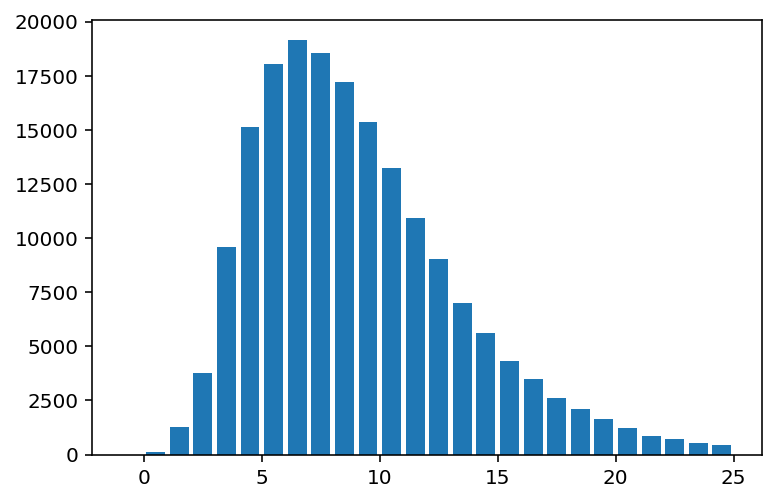

In [62]:
a= specific_hist[0]
b= specific_hist[1][:-1]
plt.bar(b,a)

## Also Tested Anomaly From Original Data Without Transformation

In [63]:
results_original = []
runs_original = []
original = []
for i in range(len(hists_validate)):
    n = hists_validate[i]
    if HistogramIntegral(n)==0:
        continue
    original.append(n)
    norm = np.multiply(n,1/HistogramIntegral(n))
    x = norm[0]
    #y = perturb_abnormal(norm)[0]
    n_components=3
    sse1, x1 = PCATest(x, pca_obj, n_components)
    results_original.append(sse1)
   # sse2, x2 = PCATest(y, pca_obj, n_components)
    #norm_with_perturb.append(y)
    #results_original.append(sse2)
    runs_original.append(runs_validate[i])

In [64]:
original_sum = []
for n in original:
    original_sum.append(sum(n[0]))

In [65]:
validate__original = []
for n in results_original:
    if n<0.05:
        validate__original.append(1)
    else:
        validate__original.append(0)

In [66]:
sum(validate__original)

522

In [67]:
len(validate__original)

596

In [68]:
len(runs_original)

596

In [69]:
original_positive = getIndex(validate__original,0)

In [70]:
runs_original = np.array(runs_original)
positive_runs = runs_original[original_positive]

In [71]:
positive_runs

array([320500, 320571, 320612, 320617, 320654, 321078, 321123, 321323,
       321383, 321386, 321388, 321586, 321607, 321665, 321683, 321728,
       321729, 321731, 321819, 321949, 321959, 322012, 322049, 322339,
       322483, 322484, 322485, 322487, 322672, 322702, 322707, 322709,
       323292, 323318, 323327, 323328, 323336, 323344, 323345, 323347,
       323348, 323349, 323413, 323558, 323560, 323652, 323653, 323716,
       323825, 324089, 324131, 324161, 324162, 324163, 324200, 324393,
       324408, 324432, 324564, 324571, 324645, 324818, 324967, 325065,
       325175, 315258, 315788, 315789, 316112, 316456, 316664, 317088,
       318944, 319310])

In [72]:
original_sum = np.array(original_sum)
original_positive_sum = original_sum[original_positive]

In [73]:
original_positive_sum

array([6.790e+02, 2.110e+02, 2.000e+00, 4.400e+01, 2.400e+01, 1.100e+01,
       1.140e+02, 1.200e+01, 8.000e+00, 6.000e+00, 7.000e+00, 1.500e+01,
       3.000e+00, 1.000e+00, 1.600e+01, 9.000e+00, 1.510e+02, 1.000e+00,
       2.000e+00, 6.000e+00, 1.000e+00, 1.200e+01, 8.000e+00, 4.000e+00,
       1.000e+00, 2.000e+00, 1.000e+00, 1.500e+01, 1.000e+00, 3.700e+01,
       1.280e+02, 4.000e+00, 2.500e+01, 3.000e+01, 4.000e+00, 6.000e+01,
       3.200e+01, 1.000e+00, 2.100e+01, 7.000e+00, 2.000e+00, 3.000e+00,
       1.900e+01, 2.000e+00, 7.000e+00, 1.000e+00, 2.000e+00, 5.000e+00,
       3.000e+00, 7.000e+00, 1.100e+01, 2.000e+00, 2.000e+00, 1.100e+01,
       8.000e+00, 3.000e+00, 8.000e+00, 3.400e+01, 2.070e+02, 1.380e+02,
       1.000e+00, 1.000e+00, 3.000e+00, 4.000e+00, 1.690e+02, 3.050e+02,
       1.000e+00, 2.000e+00, 1.000e+00, 4.751e+03, 7.200e+01, 1.250e+02,
       3.000e+00, 6.600e+01])